In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2024-12-03 13:31:51.766846: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-03 13:31:51.793333: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733250711.822551  130676 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733250711.830941  130676 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-03 13:31:51.867860: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Num GPUs Available:  1


In [2]:
import sklearn
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import os

np.random.seed(42)
tf.random.set_seed(42)

In [3]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0,1,n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10)) #wave1
    series += 0.2 * np.sin((time-offsets2) * (freq2 * 20 + 20)) # wave2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5) # + noise
    return series[..., np.newaxis].astype(np.float32)

In [4]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, n_steps], series[9000:, -1]

X_train.shape, y_train.shape

((7000, 50, 1), (7000, 1))

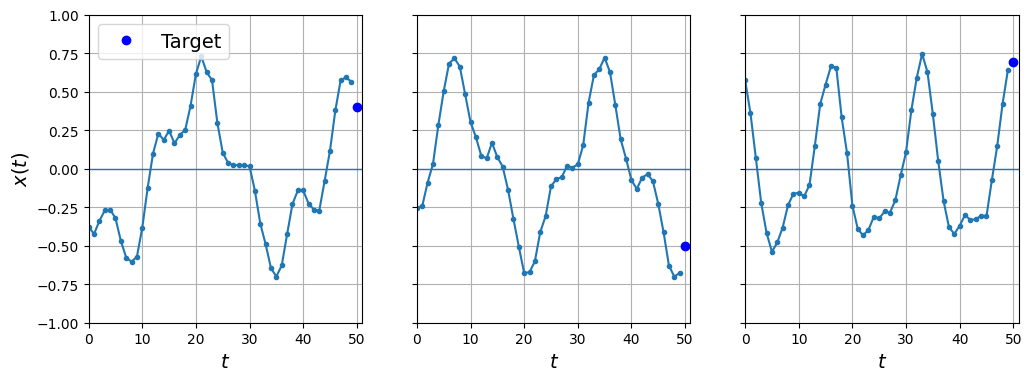

In [5]:
def plot_series(series, y=None, y_pred=None, x_label='$t$', y_label='$x(t)$', legend=True):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, 'bo', label='Target')
    if y_pred is not None:
        plt.plot(n_steps, y_pred, 'rx', markersize=10, label='Prediction')
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=14)
    if y_label:
        plt.ylabel(y_label, fontsize=14)
    plt.hlines(0,0,100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])
    if legend and (y or y_pred):
        plt.legend(fontsize=14, loc="upper left")

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12,4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=('$x(t)$' if col==0 else None), 
                legend =(col == 0))
plt.show()    

In [6]:
from tensorflow.keras.losses import MeanSquaredError
mse = MeanSquaredError()

y_pred = X_valid[:, -1]
np.mean(mse(y_valid, y_pred))

I0000 00:00:1733250716.281130  130676 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5520 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


np.float32(0.020211369)

In [7]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50,1]),
    keras.layers.Dense(1)
])

model.compile(loss='mse', optimizer='Adam')
history = model.fit(X_train, y_train, epochs=20,
          validation_data=(X_valid, y_valid))

/home/colingfly/anaconda3/envs/py31/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20


I0000 00:00:1733250717.352134  130883 service.cc:148] XLA service 0x7f51940064a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733250717.352208  130883 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Laptop GPU, Compute Capability 8.9
2024-12-03 13:31:57.362523: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1733250717.391338  130883 cuda_dnn.cc:529] Loaded cuDNN version 90300


 84/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4104  

I0000 00:00:1733250717.553864  130883 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.3105 - val_loss: 0.0762
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0546 - val_loss: 0.0290
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0240 - val_loss: 0.0186
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0166 - val_loss: 0.0147
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0134 - val_loss: 0.0125
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0115 - val_loss: 0.0110
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0101 - val_loss: 0.0097
Epoch 8/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0090 - val_loss: 0.0085
Epoch 9/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0079 - val_loss: 0.0075
Epoch 10/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0071 - val_loss: 0.0067
Epoch 11/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0064 - val_loss: 0.0060
Epoch 12/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.

In [8]:
model.evaluate(X_valid, y_valid)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0038


0.003849381348118186

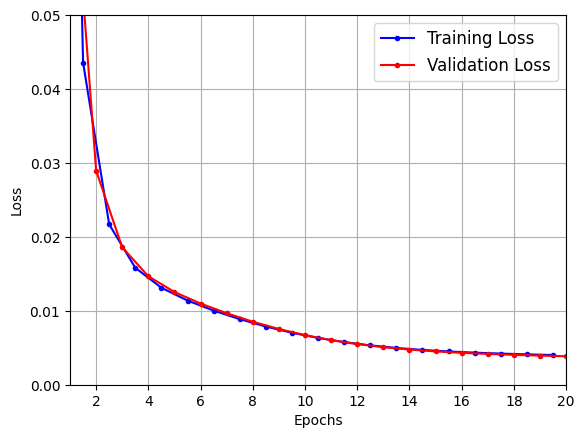

In [9]:
def plot_learning_curve(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training Loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label = "Validation Loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=12)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

plot_learning_curve(history.history['loss'], history.history['val_loss'])

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


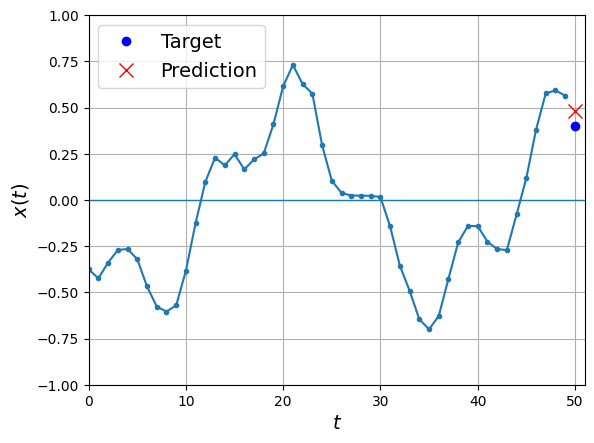

In [10]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0,0])
plt.show()

Epoch 1/20


/home/colingfly/anaconda3/envs/py31/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.2242 - val_loss: 0.0322
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0297 - val_loss: 0.0238
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0226 - val_loss: 0.0189
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0183 - val_loss: 0.0159
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0157 - val_loss: 0.0139
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0139 - val_loss: 0.0127
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0128 - val_loss: 0.0118
Epoch 8/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0121 - val_loss: 0.0113
Epoch 9/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0117 - val_loss: 0.0111
Epoch 10/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0115 - val_loss: 0.0110
Epoch 11/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0115 - val_loss: 0.0109
Epoch 12/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0

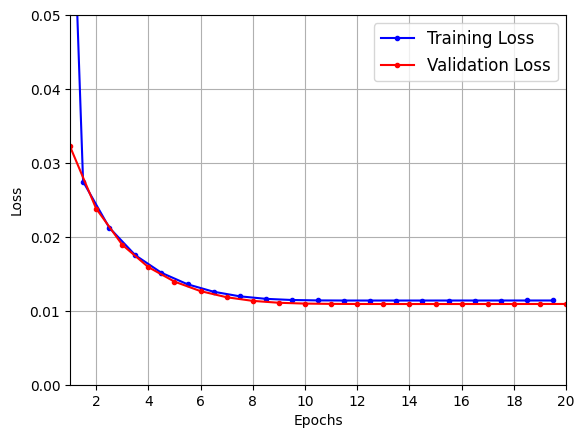

In [11]:
#Implementing a Simple RNN
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

optimizer = keras.optimizers.Adam(learning_rate=0.005)
model.compile(loss='mse', optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=20,
          validation_data=(X_valid, y_valid))

plot_learning_curve(history.history['loss'], history.history['val_loss'])

Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.0955 - val_loss: 0.0097
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0075 - val_loss: 0.0072
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0055 - val_loss: 0.0062
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0046 - val_loss: 0.0055
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0042 - val_loss: 0.0051
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0040 - val_loss: 0.0048
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0038 - val_loss: 0.0047
Epoch 8/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0037 - val_loss: 0.0044
Epoch 9/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0036 - val_loss: 0.0042
Epoch 10/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0035 - val_loss: 0.0041
Epoch 11/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0034 - val_loss: 0.0040
Epoch 12/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 1

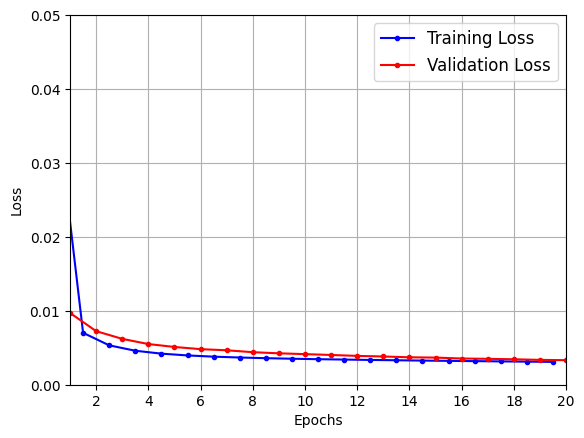

In [12]:
#Deep RNN
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None,1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1)
])

model.compile(loss='mse', optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
          validation_data=(X_valid, y_valid))

plot_learning_curve(history.history['loss'], history.history['val_loss'])

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


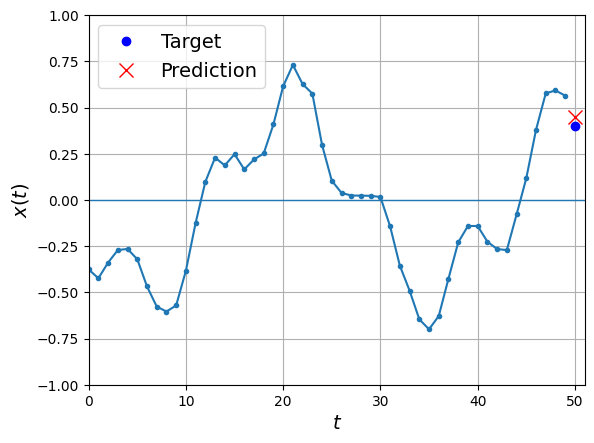

In [13]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0,0], y_pred[0,0])
plt.show()

In [14]:
#Forecasting Severeal Steps Ahead
np.random.seed(43)

series = generate_time_series(1, n_steps + 10)
X_new, Y_new = series[:, :n_steps], series[:, n_steps:]
X = X_new
for step_ahead in range(10):
    y_pred_one = model.predict(X[:, step_ahead:])[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:]
Y_pred.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


(1, 10, 1)

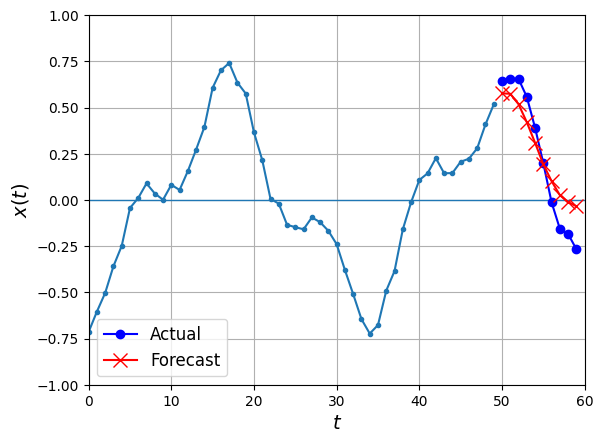

In [15]:
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "bo-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, : , 0], "rx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=12)

plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

In [16]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
X_valid, Y_valid  = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

In [17]:
X = X_valid
for step_ahead in range(10):
    y_pred_one = model.predict(X)[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:, 0]
Y_pred.shape

63/63 ━━━━━━━━━━━━━━━━━━━━ -0s -2944us/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


(2000, 10)

In [18]:
np.mean(mse(Y_valid, Y_pred))

np.float32(0.03396095)

In [19]:
Y_naive_pred = np.tile(X_valid[:, -1], 10) #last step value repeated 10 times
np.mean(mse(Y_valid, Y_naive_pred))

np.float32(0.25697407)

In [20]:
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50,1]),
    keras.layers.Dense(10)
])

model.compile(loss='mse', optimizer='adam')
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.2157 - val_loss: 0.0829
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0750 - val_loss: 0.0651
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0626 - val_loss: 0.0586
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step - loss: 0.0573 - val_loss: 0.0547
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0538 - val_loss: 0.0519
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0512 - val_loss: 0.0498
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0491 - val_loss: 0.0481
Epoch 8/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0475 - val_loss: 0.0467
Epoch 9/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0461 - val_loss: 0.0456
Epoch 10/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0450 - val_loss: 0.0446
Epoch 11/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0441 - val_loss: 0.0439
Epoch 12/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/st

In [21]:
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(10)
])

model.compile(loss='mse', optimizer='adam')
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.1309 - val_loss: 0.0417
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0426 - val_loss: 0.0305
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0345 - val_loss: 0.0258
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 23s 107ms/step - loss: 0.0304 - val_loss: 0.0243
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0270 - val_loss: 0.0235
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0250 - val_loss: 0.0229
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0240 - val_loss: 0.0224
Epoch 8/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0234 - val_loss: 0.0221
Epoch 9/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0230 - val_loss: 0.0218
Epoch 10/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0226 - val_loss: 0.0211
Epoch 11/20
219/219 ━━━━━━━━━━━━━━━━━━━━ -21s -95183us/step - loss: 0.0223 - val_loss: 0.0206
Epoch 12/20
219/219 ━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step


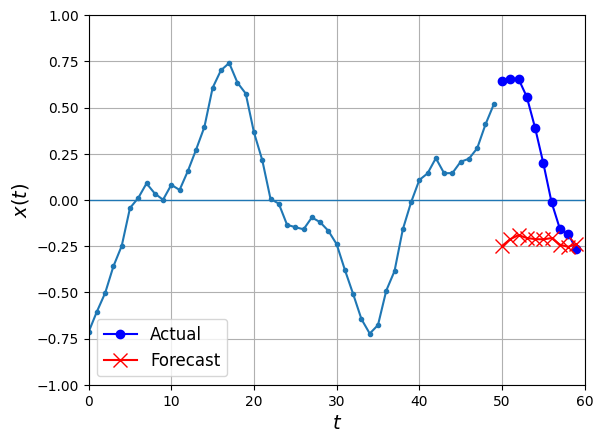

In [22]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, -10:, :]
Y_pred = model.predict(X_new)[..., np.newaxis]

plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

In [23]:
#Instead of forecasting steps 50 to 59, this method predicts the next 10 steps at each step (1-10, 2-11, etc..)
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train = series[:7000, :n_steps]
X_valid = series[7000:9000, :n_steps]
X_test = series[9000:, :n_steps]
Y = np.empty((10000, n_steps, 10))
for step_ahead in range(1, 10 + 1):
    Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

X_train.shape, Y_train.shape

((7000, 50, 1), (7000, 50, 10))

In [24]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mse(Y_true[:, -1], Y_pred[:, -1])

model.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=0.01), metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - last_time_step_mse: 0.0586 - loss: 0.0666 - val_last_time_step_mse: 0.0197 - val_loss: 0.0337
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - last_time_step_mse: 0.0215 - loss: 0.0346 - val_last_time_step_mse: 0.0150 - val_loss: 0.0289
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - last_time_step_mse: 0.0166 - loss: 0.0300 - val_last_time_step_mse: 0.0139 - val_loss: 0.0273
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - last_time_step_mse: 0.0152 - loss: 0.0280 - val_last_time_step_mse: 0.0112 - val_loss: 0.0248
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - last_time_step_mse: 0.0127 - loss: 0.0257 - val_last_time_step_mse: 0.0089 - val_loss: 0.0229
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - last_time_step_mse: 0.0098 - loss: 0.0231 - val_last_time_step_mse: 0.0089 - val_loss: 0.0213
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - last_time_step_mse: 0.0089 - loss: 0.0218 - val_last_

In [25]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


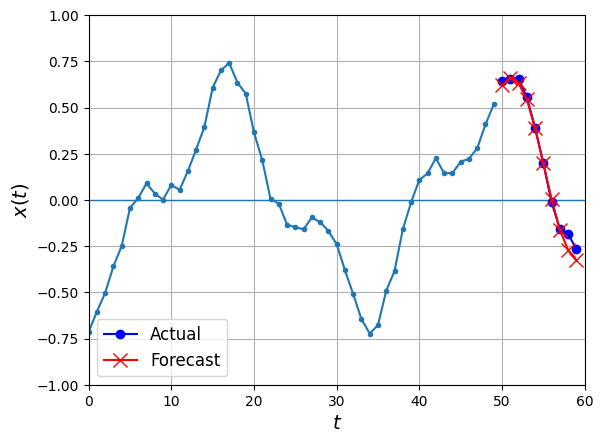

In [26]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

In [27]:
#DeepRNN with Batch Normalization

np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None,1]),
    keras.layers.BatchNormalization(),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.BatchNormalization(),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss='mse', optimizer='adam', metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 12s 32ms/step - last_time_step_mse: 0.3583 - loss: 0.3751 - val_last_time_step_mse: 0.0890 - val_loss: 0.0934
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - last_time_step_mse: 0.0492 - loss: 0.0581 - val_last_time_step_mse: 0.0413 - val_loss: 0.0525
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - last_time_step_mse: 0.0389 - loss: 0.0492 - val_last_time_step_mse: 0.0334 - val_loss: 0.0457
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - last_time_step_mse: 0.0332 - loss: 0.0440 - val_last_time_step_mse: 0.0279 - val_loss: 0.0407
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - last_time_step_mse: 0.0288 - loss: 0.0400 - val_last_time_step_mse: 0.0236 - val_loss: 0.0373
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - last_time_step_mse: 0.0245 - loss: 0.0368 - val_last_time_step_mse: 0.0207 - val_loss: 0.0355
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - last_time_step_mse: 0.0213 - loss: 0.0347 - val_last_

In [28]:
#Simple RNN with Layer Norm
from tensorflow.keras.layers import LayerNormalization

class LNSimpleRNNCell(keras.layers.Layer):
    def __init__(self, units, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = keras.layers.SimpleRNNCell(units,
                                                          activation=None)
        self.layer_norm = LayerNormalization()
        self.activation = keras.activations.get(activation)
    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]

In [29]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True,
                     input_shape=[None, 1]),
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20


/home/colingfly/anaconda3/envs/py31/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'ln_simple_rnn_cell', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/home/colingfly/anaconda3/envs/py31/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'ln_simple_rnn_cell_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


219/219 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - last_time_step_mse: 0.2421 - loss: 0.2489 - val_last_time_step_mse: 0.0527 - val_loss: 0.0658
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - last_time_step_mse: 0.0501 - loss: 0.0623 - val_last_time_step_mse: 0.0434 - val_loss: 0.0555
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - last_time_step_mse: 0.0433 - loss: 0.0537 - val_last_time_step_mse: 0.0370 - val_loss: 0.0492
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - last_time_step_mse: 0.0376 - loss: 0.0479 - val_last_time_step_mse: 0.0318 - val_loss: 0.0439
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - last_time_step_mse: 0.0330 - loss: 0.0434 - val_last_time_step_mse: 0.0321 - val_loss: 0.0417
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - last_time_step_mse: 0.0300 - loss: 0.0402 - val_last_time_step_mse: 0.0266 - val_loss: 0.0382
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - last_time_step_mse: 0.0275 - loss: 0.0379 - val_last_time_step_

In [ ]:
#LSTM
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None,1]),
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss='mse', optimizer='adam', metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - last_time_step_mse: 0.0952 - loss: 0.1046 - val_last_time_step_mse: 0.0342 - val_loss: 0.0536
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - last_time_step_mse: 0.0310 - loss: 0.0502 - val_last_time_step_mse: 0.0193 - val_loss: 0.0415
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - last_time_step_mse: 0.0183 - loss: 0.0394 - val_last_time_step_mse: 0.0139 - val_loss: 0.0354
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - last_time_step_mse: 0.0143 - loss: 0.0346 - val_last_time_step_mse: 0.0135 - val_loss: 0.0332
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - last_time_step_mse: 0.0129 - loss: 0.0323 - val_last_time_step_mse: 0.0129 - val_loss: 0.0316
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - last_time_step_mse: 0.0120 - loss: 0.0307 - val_last_time_step_mse: 0.0125 - val_loss: 0.0305
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - last_time_step_mse: 0.0112 - loss: 0.0296 - val_las

In [31]:
#Using 1D Convolutional Layers to process sequences
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Conv1D(filters=20, kernel_size=4, strides=2, padding='valid', input_shape=[None,1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss='mse', optimizer='adam', metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train[:, 3::2], epochs=20,
                    validation_data=(X_valid, Y_valid[:, 3::2]))

/home/colingfly/anaconda3/envs/py31/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - last_time_step_mse: 0.0914 - loss: 0.0976 - val_last_time_step_mse: 0.0379 - val_loss: 0.0470
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - last_time_step_mse: 0.0356 - loss: 0.0431 - val_last_time_step_mse: 0.0280 - val_loss: 0.0360
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - last_time_step_mse: 0.0278 - loss: 0.0345 - val_last_time_step_mse: 0.0194 - val_loss: 0.0291
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - last_time_step_mse: 0.0185 - loss: 0.0280 - val_last_time_step_mse: 0.0145 - val_loss: 0.0255
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - last_time_step_mse: 0.0147 - loss: 0.0252 - val_last_time_step_mse: 0.0132 - val_loss: 0.0241
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - last_time_step_mse: 0.0133 - loss: 0.0239 - val_last_time_step_mse: 0.0124 - val_loss: 0.0231
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - last_time_step_mse: 0.0124 - loss: 0.0230 - val_las

In [36]:
#WaveNet
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None,1]))
for rate in (1,2,4,8) * 2:
    model.add(keras.layers.Conv1D(filters=20, kernel_size=2, padding='causal', activation='relu', dilation_rate=rate))
model.add(keras.layers.Conv1D(filters=10, kernel_size=1))

model.compile(loss='mse', optimizer='adam', metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20, validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - last_time_step_mse: 0.0873 - loss: 0.0976 - val_last_time_step_mse: 0.0229 - val_loss: 0.0379
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - last_time_step_mse: 0.0220 - loss: 0.0361 - val_last_time_step_mse: 0.0188 - val_loss: 0.0324
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - last_time_step_mse: 0.0182 - loss: 0.0313 - val_last_time_step_mse: 0.0165 - val_loss: 0.0291
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - last_time_step_mse: 0.0157 - loss: 0.0280 - val_last_time_step_mse: 0.0144 - val_loss: 0.0267
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - last_time_step_mse: 0.0139 - loss: 0.0260 - val_last_time_step_mse: 0.0128 - val_loss: 0.0250
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - last_time_step_mse: 0.0125 - loss: 0.0246 - val_last_time_step_mse: 0.0118 - val_loss: 0.0240
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - last_time_step_mse: 0.0116 - loss: 0.0237 - val_last_time